# Lab 10

## starting point (lab in class)

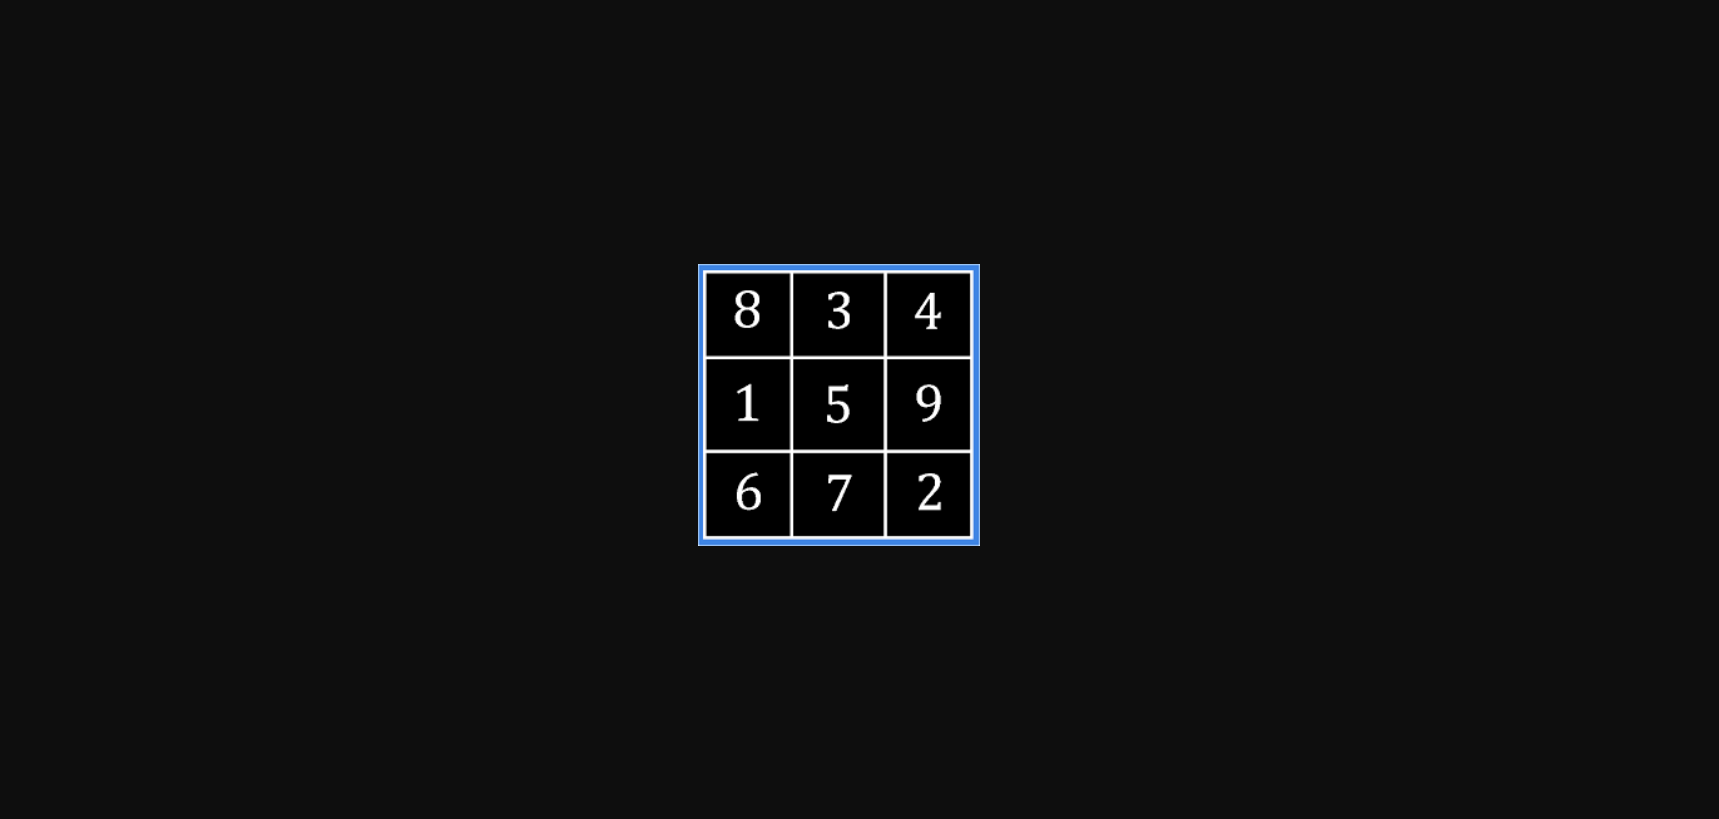

In [20]:
from random import choice
# let's play tic tac toe with the magic square knowledge background
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

MAGIC = [2, 7, 6,
         9, 5, 1,
         4, 3, 8]

State = namedtuple('State', ['x', 'o'])

def win(elements):
    # check if the elements are winning
    # if any of the combinations of 3 numbers taken randomly from 1 to 9 is equal to 15
    return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
    # evaluate state: +1 first player wins
    if win(pos.x):
      return 1
    elif win(pos.o):
      return -1
    else:
      return 0

def print_board(pos):
    for row in range(3):
      for column in range(3):
        i = row * 3 + column
        if MAGIC[i] in pos.x:
          print('x', end='')
        if MAGIC[i] in pos.o:
          print('o', end='')
        else:
          print('_', end='')
      print()
    print()


In [21]:
def random_game():
    trajectory = list()
    state = State(set(), set())
    available = set(range(1, 9+1))

    while available:
      x = choice(list(available))
      state.x.add(x)
      trajectory.append(deepcopy(state))
      available.remove(x)
      if win(state.x) or not available:
        break


      o = choice(list(available))
      state.o.add(o)
      trajectory.append(deepcopy(state))
      available.remove(o)
      if win(state.o):
        break

    return trajectory

# main loop
value_dictionary = defaultdict(float)
hit_state = defaultdict(int)
epsilon = .001

for steps in tqdm(range(1000)):
  trajectory = random_game()
  final_reward = state_value(trajectory[-1])
  # it's a cumulative sum
  for state in trajectory:
    hashable_state = (frozenset(state.x), frozenset(state.o))
    hit_state[hashable_state] += 1 # times of the moves
    value_dictionary[hashable_state] = value_dictionary[hashable_state] + epsilon*(final_reward - value_dictionary[hashable_state])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
sorted(hit_state.items(), key = lambda e: e[1], reverse = True)[:10]

[((frozenset({8}), frozenset()), 129),
 ((frozenset({7}), frozenset()), 125),
 ((frozenset({4}), frozenset()), 121),
 ((frozenset({1}), frozenset()), 114),
 ((frozenset({6}), frozenset()), 112),
 ((frozenset({2}), frozenset()), 103),
 ((frozenset({9}), frozenset()), 102),
 ((frozenset({5}), frozenset()), 98),
 ((frozenset({3}), frozenset()), 96),
 ((frozenset({8}), frozenset({7})), 22)]

In [23]:
len(hit_state)

3214

## Q Learning

In [24]:
from random import choice
# let's play tic tac toe with the magic square knowledge background
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

In [25]:
import random
# let's play tic tac toe with the magic square knowledge background
import numpy as np
from itertools import combinations
from collections import namedtuple, defaultdict
from copy import deepcopy
from tqdm.auto import tqdm

State = namedtuple('State', ['x', 'o'])

MAGIC = [2, 7, 6,
         9, 5, 1,
         4, 3, 8]

def win(elements):
    # check if the elements are winning
    # if any of the combinations of 3 numbers taken randomly from 1 to 9 is equal to 15
    return any(sum(c) == 15 for c in combinations(elements, 3))

def state_value(pos: State):
    # evaluate state: +1 first player wins
    if win(pos.x):
      return 1
    elif win(pos.o):
      return 0
    else:
      return -1

def print_board(pos):
    for row in range(3):
      for column in range(3):
        i = row * 3 + column
        if MAGIC[i] in pos.x:
          print('x', end='')
        if MAGIC[i] in pos.o:
          print('o', end='')
        else:
          print('_', end='')
      print()
    print()

In [26]:
class RandomPlayer:
  def __init__(self, x_or_o):
      self.x_or_o = x_or_o
      self.wins = 0
      self.value_dictionary = defaultdict(float)
      self.alpha = 0.1
      self.decay_gamma = 0.9

  def move(self, available, state = None):
      return random.choice(list(available))

  def feedReward(self, state, reward, action):
      hashable_state = (frozenset(state.x), frozenset(state.o))
      self.value_dictionary[(hashable_state, action)] += self.alpha * (self.decay_gamma * reward - self.value_dictionary[(hashable_state, action)])
      r = self.value_dictionary[(hashable_state, action)]
      return r

In [27]:
class QLearningAgent:
    def __init__(self, x_or_o, epsilon=0.1, alpha=0.2, gamma=0.9):
        # Q-values: {(state, action): value}
        self.x_or_o = x_or_o
        # self.q_values = defaultdict(float)
        self.q_values = {}
        self.epsilon = epsilon  # balance between exploration and exploitation
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.wins = 0

    def do_it_random(self, available, state):
        move = random.choice(list(available))
        current_state = deepcopy(state)
        current_state.x.add(move)
        # if (frozenset(state.x), frozenset(state.o)) not in self.value_dictionary.keys():
        self.q_values[(frozenset(state.x), frozenset(state.o))] = epsilon
        return move

    def get_q_value(self, state, action):
        hashable_state = (frozenset(state.x), frozenset(state.o))
        # return self.q_values[(hashable_state, action)]
        return self.q_values.get((hashable_state, action), 0.0)

    def move(self, available, state):
        best_move = None
        if random.uniform(0, 1) <= epsilon:
          # do a random move
          move = self.do_it_random(available, state)
          best_move = move
        else:
            # exploitation phase: choose the move with the highest value of q
            q_values = [self.get_q_value(state, action) for action in available]
            # hashable_state = (frozenset(state.x), frozenset(state.o))
            # q_values = [self.q_values[(hashable_state, action)]  for action in available]
            max_q_value = max(q_values)
            best_actions = [action for action, q_value in zip(available, q_values) if q_value == max_q_value]
            best_move = random.choice(best_actions)

        return best_move

    def update_q_value(self, state, action, reward, next_state):
        max_next_q_value = max(self.get_q_value(next_state, next_action) for next_action in range(1, 10))
        updated_q_value = (1 - self.alpha) * self.get_q_value(state, action) + self.alpha * (reward + self.gamma * max_next_q_value)
        hashable_state = (frozenset(state.x), frozenset(state.o))

        self.q_values[(hashable_state, action)] = updated_q_value

    def return_lr(self, state, reward, action):
        hashable_state = (frozenset(state.x), frozenset(state.o))
        self.q_values[(hashable_state, action)] += self.alpha * (self.decay_gamma * reward - self.q_values[(hashable_state, action)])
        r = self.q_values[(hashable_state, action)]
        self.alpha *= self.decay_gamma
        return self.alpha

    def feedReward(self, state, reward, action):
        hashable_state = (frozenset(state.x), frozenset(state.o))
        if hashable_state in self.q_values.keys():
          self.q_values[(hashable_state, action)] += self.alpha * (self.decay_gamma * reward - self.q_values[(hashable_state, action)])
          r = self.q_values[(hashable_state, action)]
        else:
          r = -0.5
        return r

def game(player1, player2):
    trajectory = list()
    state = State(set(), set())
    available = set(range(1, 9+1))

    players = [player1, player2]
    first_player = random.choice([0, 1])
    while available:
      current_player = players[first_player]

      move = current_player.move(list(available), state)

      # x = random.choice(list(available))
      if current_player.x_or_o == 1: # move = put a x
        state.x.add(move)
        trajectory.append(deepcopy(state))
        available.remove(move)
        if win(state.x) or not available:
          # current_player.wins += 1
          player2.wins += 1
          break

      else: # move = put a o
        # o = random.choice(list(available))
        state.o.add(move)
        trajectory.append(deepcopy(state))
        available.remove(move)
        if win(state.o):
          # current_player.wins += 1
          player1.wins += 1
          break

      first_player = 1 - first_player # if player 0 started, now it's the turn of player 1

    return trajectory, move


def give_reward(state, player1, player2, action):
    # result = win(state.x)
    if win(state.x): # x won
      player1.feedReward(state, 1, action)
      fr = player2.feedReward(state, -0.5, action)
    elif win(state.o): # o won
      player1.feedReward(state, -0.5, action)
      fr =  player2.feedReward(state, 1, action)
    else: # nobody won
      player1.feedReward(state, 0.1, action)
      fr = player2.feedReward(state, 0.1, action)
    return fr


# player1 = RandomPlayer(0) # o
# player2 = QLearningAgent(1) # x
epsilon = 0.1

def train(player1, player2, matches = 10_000):
    for _ in range(matches):
        trajectory, action = game(player1, player2)
        # print(trajectory)
        reward = give_reward(trajectory[-1], player1, player2, action)

        for state in trajectory:
            player2.update_q_value(state, action, -reward, trajectory[-1])

    win_percentage = player2.wins / matches * 100
    print(f'The Q-learning agent wins {win_percentage}% of the times in training.')


def test(player1, player2, test_matches=1000):
    player2.wins = 0

    for _ in range(test_matches):
        trajectory, action = game(player1, player2)

    win_percentage = player2.wins / test_matches * 100
    print(f'The Q-learning agent wins {win_percentage}% of the times in testing.')


if __name__ == "__main__":
    player1 = RandomPlayer(0)
    player2 = QLearningAgent(1)

    train(player1, player2)
    test(player1, player2)

The Q-learning agent wins 79.36% of the times in training.
The Q-learning agent wins 86.3% of the times in testing.


_________________